## Практическое задание к уроку № 5 по теме "Случайный лес".

In [1]:
%matplotlib inline

from collections import Counter
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn import datasets, model_selection

Модифицируем алгоритм реализации дерева решений с прошлого  
практического задания для создания случайного леса, взяв некоторые функции  
из кода урока, также напишем функции для реализации out-of-bag:

In [2]:
def calc_logloss(y, p):
    p = np.clip(p, 1e-16, 1-1e-16)
    return (- y * np.log(p) - (1.0 - y) * np.log(1.0 - p)).mean()

In [3]:
class RandomForest:
    
    def __init__(self, data, labels, n_trees=1, criterion='gini', min_leaf=5, max_depth=np.inf, random_state=0):
        
        random.seed(random_state)
        self.forest = self.random_forest(data, labels, n_trees, criterion, min_leaf, max_depth)
        self.data = data
        self.labels = labels
        self.criterion = criterion
    
    class Node:
        
        def __init__(self, index, t, true_branch, false_branch):
            
            self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t  # значение порога
            self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
    
    class Leaf:
        
        def __init__(self, data, labels, criterion):
            
            self.data = data
            self.labels = labels
            self.criterion = criterion
            self.prediction = self.predict()
    
        def predict(self):
            
            if self.criterion == 'regression':
                return self.labels.mean()
            
            else:
                classes = Counter(self.labels)
                return max(classes, key=classes.get)
    
    def get_bootstrap(self, data, labels, n):
        n_samples = data.shape[0]
        bootstrap = []
        
        for i in range(n):
            
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            oob_indexes = set(range(n_samples))
            indexes = set()

            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                indexes.add(sample_index)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]
            oob_indexes -= indexes
            bootstrap.append((b_data, b_labels, oob_indexes))

        return bootstrap
    
    def get_subsample(self, len_sample):
        return random.sample(range(len_sample), k=int(np.sqrt(len_sample)))
    
    # Расчет критерия информативности
    def impurity_criterion(self, labels, criterion):
        
        if criterion == 'gini':
            classes = Counter(labels)
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2
                
        elif criterion == 'entropy':
            classes = Counter(labels)
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p * np.log2(p) if p != 0 else 0
        
        elif criterion == 'regression':
            impurity = ((labels - labels.mean())**2).sum() / labels.shape[0]
        
        return impurity
    
    # Расчет качества
    def quality(self, left_labels, right_labels, criterion, current_criterion):
        
        # доля выборки, ушедшая в левое поддерево
        p = left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_criterion - p * self.impurity_criterion(left_labels, criterion) - (1 - p) * self.impurity_criterion(right_labels, criterion)
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels, criterion, min_leaf):
        
        current_criterion = self.impurity_criterion(labels, criterion)
        
        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
    
        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = self.get_subsample(n_features)
        
        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                
                #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
                    
                current_quality = self.quality(true_labels, false_labels, criterion, current_criterion)
                
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
        
        return best_quality, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, criterion, min_leaf, max_depth):
        
        quality, t, index = self.find_best_split(data, labels, criterion, min_leaf)
    
        #  Базовый случай - прекращаем рекурсию, когда нет прироста качества
        #  или достигнут критерий останова

        if (max_depth == 0) or (quality == 0):
            return self.Leaf(data, labels, criterion)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        # Рекурсивно строим два поддерева, обращая внимание на критерий останова
        true_branch = self.build_tree(true_data, true_labels, criterion, min_leaf, max_depth=max_depth-1)
        false_branch = self.build_tree(false_data, false_labels, criterion, min_leaf, max_depth=max_depth-1)
        
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, true_branch, false_branch)
    
    def random_forest(self, data, labels, n_trees, criterion, min_leaf, max_depth):
        
        forest = []
        bootstrap = self.get_bootstrap(data, labels, n_trees)

        for b_data, b_labels, oob_indexes in bootstrap:
            forest.append((self.build_tree(b_data, b_labels, criterion, min_leaf, max_depth), oob_indexes))

        return forest

    def predict_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)
    
    # функция формирования предсказания по выборке на одном дереве
    def predict(self, data, tree):
        
        if self.criterion == 'regression':
            return [self.predict_object(obj, tree) for obj in data]
        
        else:
            classes = []
            for obj in data:
                prediction = self.predict_object(obj, tree)
                classes.append(prediction)
            return classes
    
    # предсказание голосованием деревьев
    def tree_vote(self, data, probas=False):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree, _ in self.forest:
            predictions.append(self.predict(data, tree))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев, либо, в случае
        # регрессии, среднее значение предсказаний
        
        if probas or self.criterion == 'regression':
            return [np.mean(obj) for obj in predictions_per_object]
        
        else:
            voted_predictions = []
            for obj in predictions_per_object:
                voted_predictions.append(max(set(obj), key=obj.count))

            return voted_predictions
    
    def out_of_bag(self):
        
        logloss = []
        
        for idx, obj in enumerate(self.data):
            answers = []
            for tree, oob_indexes in self.forest:
                if idx in oob_indexes:
                    answer = self.predict([obj], tree)
                    answers.append(answer)
            
            if answers:
                p = np.array(answers).mean()
                logloss.append(calc_logloss(self.labels[idx], p))
        
        return np.array(logloss).mean()

#### Задание 1.   
* *Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками.*  
* *Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).*  
* *Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).*  
* *Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.*

Дан датасет:

In [4]:
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=2, n_informative=2, 
                                    n_classes=2, n_redundant=0, 
                                    n_clusters_per_class=2, flip_y=0.1, random_state=1)

Визуализируем сгенерированные данные:

In [5]:
plt.rcParams.update({'font.size': 14})

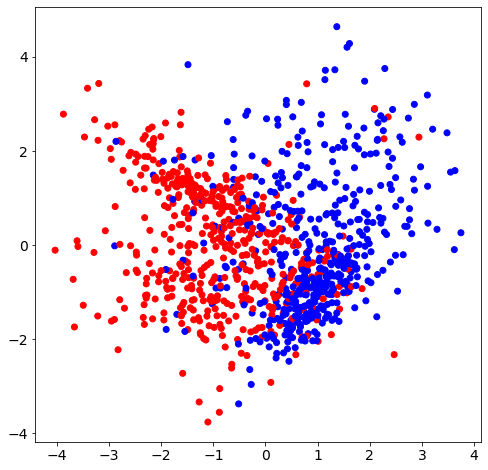

In [6]:
colors = ListedColormap(['red', 'blue'])

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors)

plt.show()

Разобъём датасет на обучающую и тестовую выборки:

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=29)

Обучим модели случайного леса:

In [8]:
model_1 = RandomForest(X_train, y_train, n_trees=1, min_leaf=1, random_state=29)

In [9]:
model_3 = RandomForest(X_train, y_train, n_trees=3, min_leaf=1, random_state=29)

In [10]:
model_10 = RandomForest(X_train, y_train, n_trees=10, min_leaf=1, random_state=29)

In [11]:
model_50 = RandomForest(X_train, y_train, n_trees=50, min_leaf=1, random_state=29)

In [12]:
model_100 = RandomForest(X_train, y_train, n_trees=100, min_leaf=1, random_state=29)

In [13]:
model_200 = RandomForest(X_train, y_train, n_trees=200, min_leaf=1, random_state=29)

Напишем функцию для расчёта метрики:

In [14]:
def calc_f1(y_pred, y):
    
    TN = ((y == 0) & (y_pred == 0)).sum()
    FP = ((y == 0) & (y_pred == 1)).sum()
    FN = ((y == 1) & (y_pred == 0)).sum()
    TP = ((y == 1) & (y_pred == 1)).sum()
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    return 2 * precision * recall / (precision + recall)

Для визуализации разделяющих линий воспользуемся кодом с урока № 4:

In [15]:
def visualize(model, X_train, X_test, y_train, y_test):

    def get_meshgrid(data, step=0.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize = (16, 7))
    plt.rcParams.update({'axes.grid': False})
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(X_train)
    mesh_predictions = np.array(model.tree_vote(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=colors)
    plt.title(f'Train F1-score={calc_f1(np.array(model.tree_vote(X_train)), y_train):.3f}')
    
    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=colors)
    plt.title(f'Test F1-score={calc_f1(np.array(model.tree_vote(X_test)), y_test):.3f}')
    
    plt.show()

### 1 Дерево:

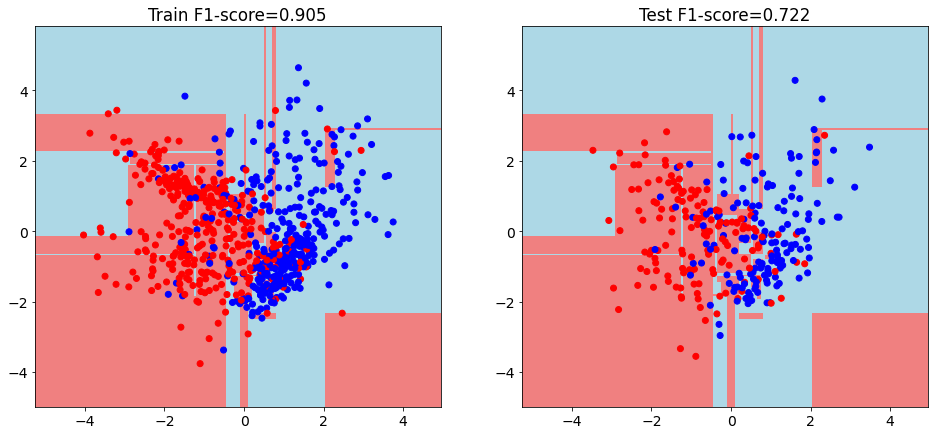

In [16]:
visualize(model_1, X_train, X_test, y_train, y_test)

### 3 Дерева:

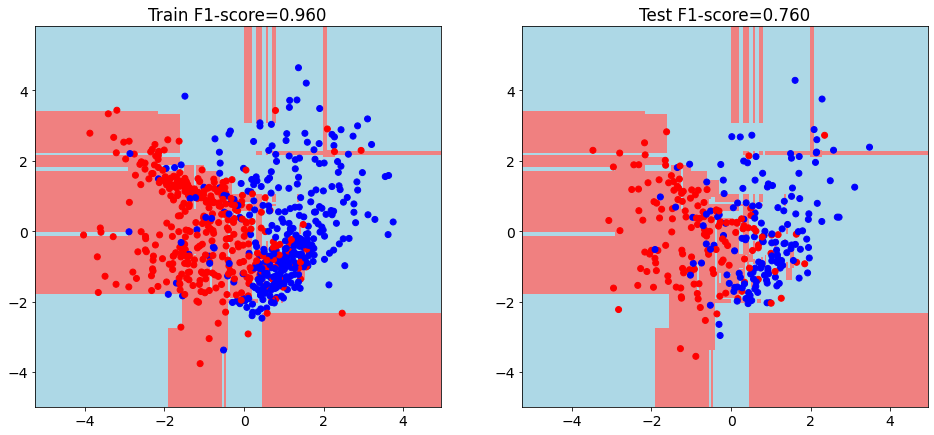

In [17]:
visualize(model_3, X_train, X_test, y_train, y_test)

### 10 Деревьев:

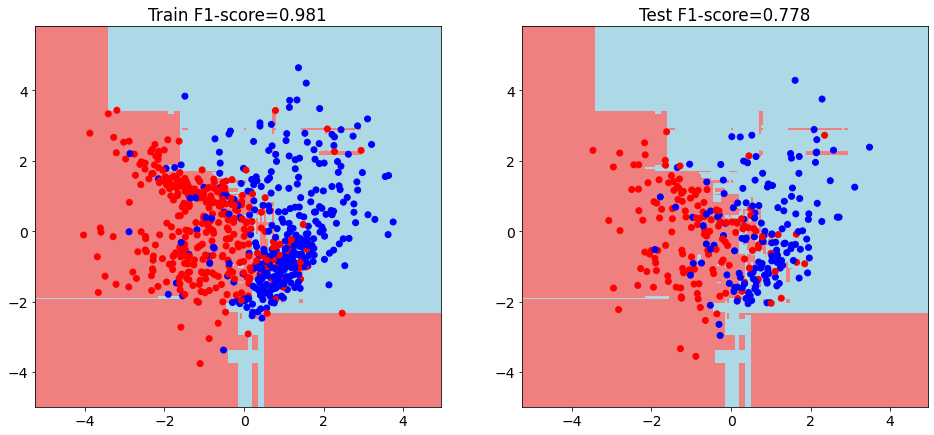

In [18]:
visualize(model_10, X_train, X_test, y_train, y_test)

### 50 Деревьев:

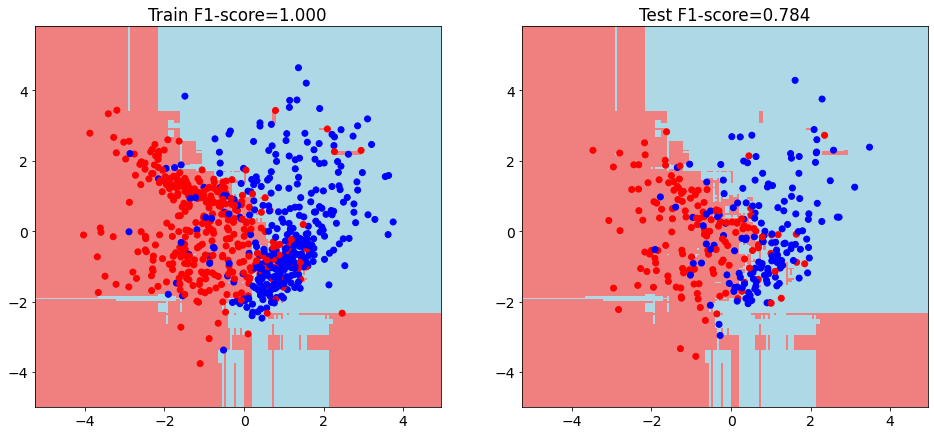

In [19]:
visualize(model_50, X_train, X_test, y_train, y_test)

### 100 Деревьев:

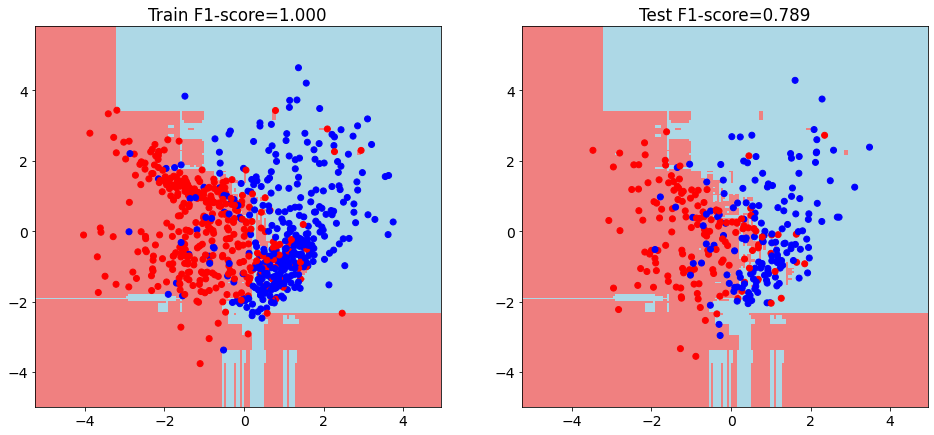

In [20]:
visualize(model_100, X_train, X_test, y_train, y_test)

### 200 Деревьев:

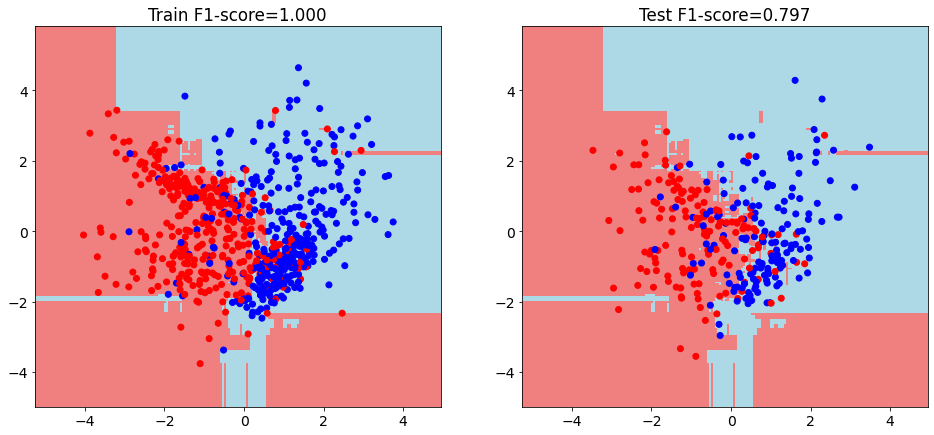

In [21]:
visualize(model_200, X_train, X_test, y_train, y_test)

Изобразим метрики моделей на графике:

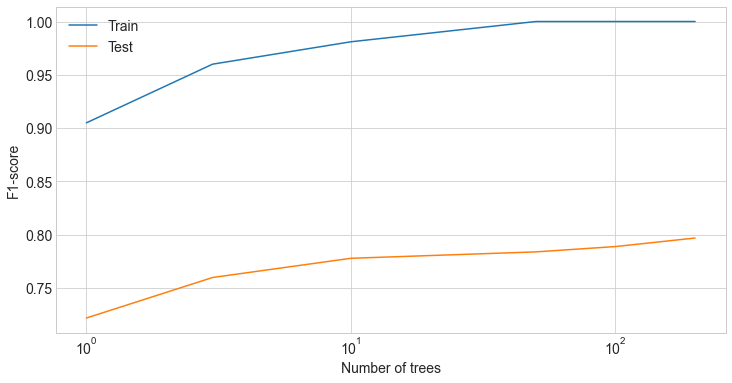

In [22]:
n_trees = np.array([1, 3, 10, 50, 100, 200])
f1_train = np.array([0.905, 0.960, 0.981, 1, 1, 1])
f1_test = np.array([0.722, 0.760, 0.778, 0.784, 0.789, 0.797])

plt.figure(figsize = (12, 6))
plt.style.use('seaborn-whitegrid')

plt.plot(n_trees, f1_train, label='Train')
plt.plot(n_trees, f1_test, label='Test')
plt.xscale('log')
plt.xlabel('Number of trees')
plt.ylabel('F1-score')
plt.legend()

plt.show()

Исходя из представленных выше графиков можно сделать вывод, что разделяющая гиперплоскость получается рваной и плохо читаемой. Скорее всего, это связано с принципом работы нашего алгоритма случайного леса, генерирующего случайные бутстрап-выборки и выбирающего 1 признак из 2-х при каждом разбиении, а также с отсутствием ограничений деревьев на глубину и количество объектов в листьях. Даже при количестве деревьев, при котором мы имеем идеальные предсказания на тестовой выборке, на графике мы видим, что некоторые объекты якобы классифицированы неверно. На самом деле там существует невидимое нам разделение, которое визуально меньше размера маркера точек.  
Касательно метрик отметим, что с увеличением сложности модели растёт её качество. Даже модель с 200 деревьев не показывает признаков переобучения, несмотря на идеальную подстройку к обучающей выборке.

#### Задание 2.  
*Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.*

Обучим модели аналогично заданию 1, но используя всю выборку:

In [23]:
model_oob_1 = RandomForest(X, y, n_trees=1, min_leaf=1, random_state=29)

In [24]:
model_oob_3 = RandomForest(X, y, n_trees=3, min_leaf=1, random_state=29)

In [25]:
model_oob_10 = RandomForest(X, y, n_trees=10, min_leaf=1, random_state=29)

In [26]:
model_oob_50 = RandomForest(X, y, n_trees=50, min_leaf=1, random_state=29)

In [27]:
model_oob_100 = RandomForest(X, y, n_trees=100, min_leaf=1, random_state=29)

In [28]:
model_oob_200 = RandomForest(X, y, n_trees=200, min_leaf=1, random_state=29)

Сравним LogLoss моделей с отложенной выборкой на test-выборке с Out-of-bag LogLoss моделей, которые обучались на всей выборке:

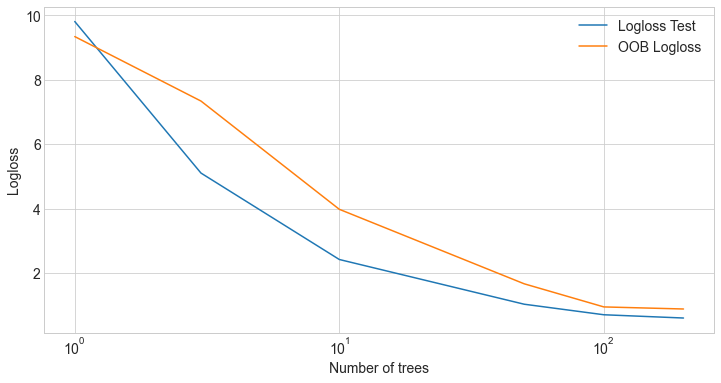

In [29]:
n_trees = np.array([1, 3, 10, 50, 100, 200])
models = [model_1, model_3, model_10, model_50, model_100, model_200]
models_oob = [model_oob_1, model_oob_3, model_oob_10, model_oob_50, model_oob_100, model_oob_200]

logloss = []
for model in models:
    logloss.append(calc_logloss(y_test, model.tree_vote(X_test, probas=True)))
    
logloss_oob = [model.out_of_bag() for model in models_oob]

plt.figure(figsize = (12, 6))
plt.style.use('seaborn-whitegrid')

plt.plot(n_trees, logloss, label='Logloss Test')
plt.plot(n_trees, logloss_oob, label='OOB Logloss')
plt.xscale('log')
plt.xlabel('Number of trees')
plt.ylabel('Logloss')
plt.legend()

plt.show()

Обе эти линии показывают ошибку алгоритмов при предсказании на незнакомых им данных. Отличие в том, что в одном случае (синяя линия) группа моделей обучалась на доле выборки и предсказывала на отложенной выборке. В другом случае (оранжевая линия) группа моделей обучалась на всей выборке, но предсказания по каждому объекту делали только те деревья, которые не обучались на данном объекте.  
Можно сделать вывод, что в нашем случае отложенная выборка оказалась более эффективна, хотя при увеличении числа деревьев в модели разница между ошибками снижалась. Предположу, что показатели "оранжевой" группы моделей оказались хуже ввиду того, что предсказания на отдельном объекте делает малое, по сравнению с "синей" группой, количество деревьев. Этот недостаток нивелируется при увеличении числа деревьев в модели.